The problem definition is that we have a sequence of images and we need to predict a sequence of steering wheel angles . So this is a type of regression problem .

For simplicity , we will pose the problem as predicting a steering wheel angle(some real value) given an image . i.e. a CNN - regression problem .

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mounting google drive to use the data directly in colab

In [35]:
!unzip /content/drive/MyDrive/driving_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: driving_dataset/33032.jpg  
  inflating: driving_dataset/33149.jpg  
  inflating: driving_dataset/3315.jpg  
  inflating: driving_dataset/33158.jpg  
  inflating: driving_dataset/33160.jpg  
  inflating: driving_dataset/33164.jpg  
  inflating: driving_dataset/33167.jpg  
  inflating: driving_dataset/33199.jpg  
  inflating: driving_dataset/33239.jpg  
  inflating: driving_dataset/33267.jpg  
  inflating: driving_dataset/3342.jpg  
  inflating: driving_dataset/33473.jpg  
  inflating: driving_dataset/3352.jpg  
  inflating: driving_dataset/33524.jpg  
  inflating: driving_dataset/33678.jpg  
  inflating: driving_dataset/33689.jpg  
  inflating: driving_dataset/3370.jpg  
  inflating: driving_dataset/33705.jpg  
  inflating: driving_dataset/33715.jpg  
  inflating: driving_dataset/33726.jpg  
  inflating: driving_dataset/33734.jpg  
  inflating: driving_dataset/33766.jpg  
  inflating: driving_dataset/33816.jpg  
  inflatin

Extracted the data folder

In [36]:
import torch
import torch.nn as nn 
import torch.optim as optim  
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd
from PIL import Image
from torch.utils.data import (
    Dataset,
    DataLoader,
)

Imported necessary libraries

In [37]:
class RegressionDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        with open(txt_file) as f:
            self.data = f.readlines()
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        line = self.data[index].strip().split()
        img_path = os.path.join(self.root_dir, line[0])
        image = Image.open(img_path)
        target = float(line[1])

        if self.transform:
            image = self.transform(image)

        return (image, target)

Constructed custom dataset for loading data

In [38]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Necessary transformations on image

In [40]:
dataset = RegressionDataset(
    txt_file="/content/drive/MyDrive/data.txt",
    root_dir="driving_dataset",
    transform=transform
)

In [21]:
'''dataloader = DataLoader(
    dataset,
    batch_size=10,
    shuffle=True,
    num_workers=1,
)'''

'dataloader = DataLoader(\n    dataset,\n    batch_size=10,\n    shuffle=True,\n    num_workers=1,\n)'

In [41]:
from torch.utils.data import random_split

train_dataset, test_dataset = random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Splitted the data with 80% as train data and 20% as test data  then constructed data loader for both train and test dataset

In [42]:
images , targets = next(iter(train_dataloader))

In [43]:
images.shape

torch.Size([32, 3, 256, 256])

In [44]:
targets.shape

torch.Size([32])

labels : tensor([ 14.2200,  -5.7500,  -2.3200,   5.5500,  14.4200,   0.9100,   0.8100,
         14.2200,   0.0000,   0.6100,  -2.3200, 188.3700,  -9.0800, -11.6000,
          0.0000,  -6.9600,  -2.4200,  -0.6100,   7.8700,   3.5300,   0.0000,
        -17.1400, -16.4400,   5.8500,  -7.7600,   1.1100,   0.2000,   0.0000,
         11.3900,  23.9000,  -5.2400, -13.0100], dtype=torch.float64)


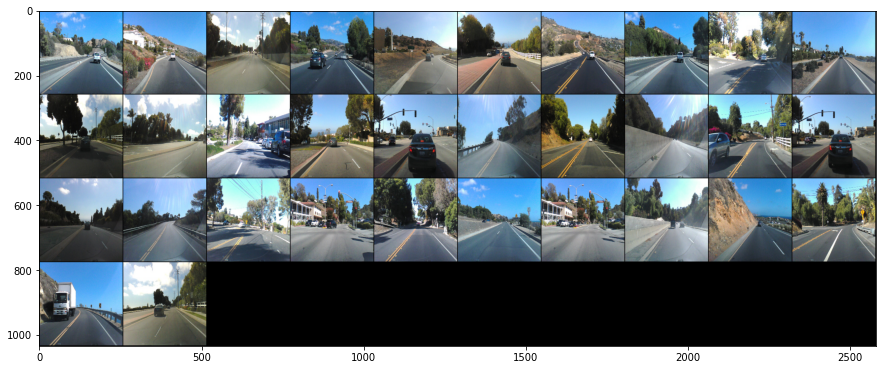

In [45]:
import numpy as np
import matplotlib.pyplot as plt
grid = torchvision.utils.make_grid(images,nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print(f"labels : {targets}")

Visualization of our images

In [46]:
len(train_dataloader)

1136

In [47]:
len(test_dataloader)

284

In [ ]:
class CustomNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(32, 64, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [48]:
class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 24, kernel_size = 5, stride = 2 ),
            nn.ELU(),
        
            nn.Conv2d(24, 36, kernel_size = 5, stride = 2),
            nn.ELU(),

            nn.Conv2d(36, 48, kernel_size = 5, stride = 2),
            nn.ELU(),

            nn.Conv2d(48, 64, kernel_size = 3, stride = 1 ),
            nn.ELU(),

            nn.Conv2d(64, 64, kernel_size = 3, stride = 1),
            nn.ELU(),

            nn.Dropout(0.5),
            
            nn.Linear(25,100),
            nn.ELU(),

            nn.Linear(100,50),
            nn.ELU(),

            nn.Linear(50,10),
            #nn.ELU(),

            nn.Linear(10,1),
        )
    
    def forward(self, xb):
        return self.network(xb)

Buiding our custom network

In [49]:
network = MyNetwork()
print(network)

MyNetwork(
  (network): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ELU(alpha=1.0)
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=25, out_features=100, bias=True)
    (12): ELU(alpha=1.0)
    (13): Linear(in_features=100, out_features=50, bias=True)
    (14): ELU(alpha=1.0)
    (15): Linear(in_features=50, out_features=10, bias=True)
    (16): Linear(in_features=10, out_features=1, bias=True)
  )
)


Created an instance of our custom network

In [50]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.1)

for epoch in range(2):
    total_loss = 0
    #for i, (images, targets) in enumerate(train_dataloader):
    for item in train_dataloader:
        images , targets = next(iter(train_dataloader))
        #targets = targets.float()
        targets = targets.view(-1, 1, 1, 1).float()
        #targets = torch.tensor(targets).view(-1, *images.shape[1:])

        preds = network(images)
        loss = criterion(preds, targets)

        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    avg_loss = total_loss / len(train_dataloader)
    print("epoch:",epoch,"loss:",avg_loss)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 64, 25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 loss: 1669238638027.6804
epoch: 1 loss: 1033.5785789556905


Training for a few epochs .
Everything is running well .

In [59]:
from google.colab import files
torch.save(network.state_dict(), 'mynetwork.pth.tor')
files.download('mynetwork.pth.tor')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
PATH = "state_dict_model.pt"
torch.save(network.state_dict(), PATH)

In [56]:
print(torch.__version__)

1.13.1+cu116


In [60]:
state_dict = torch.load('model.pt')

In [61]:
print(state_dict)

OrderedDict([('network.0.weight', tensor([[[[-0.4281, -0.4131, -0.4604, -0.3567, -0.3285],
          [-0.3237, -0.5084, -0.3229, -0.3963, -0.4821],
          [-0.5002, -0.4720, -0.3850, -0.3801, -0.3496],
          [-0.4829, -0.2986, -0.2861, -0.3811, -0.3452],
          [-0.3726, -0.4227, -0.4278, -0.5086, -0.3721]],

         [[-0.3164, -0.4890, -0.3252, -0.3153, -0.4756],
          [-0.3270, -0.3685, -0.3638, -0.4657, -0.4025],
          [-0.4051, -0.3154, -0.4779, -0.4072, -0.3500],
          [-0.2916, -0.3803, -0.2894, -0.4942, -0.2913],
          [-0.5061, -0.3034, -0.3704, -0.3051, -0.3243]],

         [[-0.4938, -0.3110, -0.3401, -0.3103, -0.3754],
          [-0.4648, -0.4758, -0.4304, -0.5064, -0.4408],
          [-0.3282, -0.4415, -0.4320, -0.3335, -0.4662],
          [-0.3696, -0.4621, -0.2955, -0.4880, -0.4748],
          [-0.4311, -0.4854, -0.3671, -0.4967, -0.4457]]],


        [[[-0.9343, -0.9225, -0.8692, -0.8672, -0.7638],
          [-0.8819, -0.7394, -0.8288, -0.7931,

In [63]:
import cv2
img = cv2.imread('car.jpg')


In [64]:
img.shape

(854, 1280, 3)

In [72]:
rows,cols,channels = img.shape

In [68]:
import os 
import scipy.misc
from scipy import pi
smoothed_angle = 0
xs = []
ys = []

In [69]:
with open("/content/drive/MyDrive/data.txt") as f:
    for line in f:
        xs.append("/content/driving_dataset" + line.split()[0])
        ys.append(float(line.split()[1]) * scipy.pi / 180)

In [70]:
num_images = len(xs)
print(num_images)

45406


In [71]:
import math
i = math.ceil(num_images*0.7)
print("Starting frameofvideo:" +str(i))

Starting frameofvideo:31785
